# SUB-BENCHMARK 2: Comparison of the jDR methods on cancer datasets

We here reproduce the second sub-benchmark proposed in the paper. We thus compare here the performances of the various jDR methods on the integration of multi-omics cancer datasets from TCGA. The methods are evaluated regarding associations to clinical annotations, survival and biological annotations (GO, REACTOME, Hallmarks).

## Comparison based on clinical annotations

We define here a function that performs the jDR comparison based on their association to clinical annotations. In particular, we here compute the number of clinical annotations significantly associated with at least one factor, and their selectivity (see Methods paper). The clinical metadata need to be stored in a clinical folder containing files named according to each cancer type. 

In [40]:
## Perform clinical annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# clinical = clinical information associated with samples
# col = columns in clinical data on which the analysis will be performed
## OUPUTS: a list containing output values
# selectivity = Selectivity (fraction of significant annotations per all significant factors)
# nonZeroFacs = Number of unique factors that were significant at least once
# total_pathways = Number of clinical annotations with at least one significant factor component
clinical_comparison <- function(factorizations, clinical, col){

    # Empty containers
    selectivity <- numeric(0) # Updated labels to be meaningful
    non_zero_facs <- numeric(0)
    total_sig_clinical_measures <- numeric(0)
    cancer_label <- list()
    #line <- numeric(0)
    #line2 <- numeric(0)
    #line3 <- numeric(0)

    # For each factorization
    for(i in 1:length(factorizations)){

        # Extract sample association
        factors <- factorizations[[i]][[1]]
        if(is.null(names(factors))) { names(factors) <- 1:ncol(factors) }
        if(is.null(colnames(factors))) { colnames(factors) <- 1:ncol(factors) }

        # Patient names in factorisation results
        patient.names <- rownames(factors)
        # Patient names in original data
        patient.names.in.file <- as.character(clinical[, 1])
        patient.names.in.file <- toupper(gsub('-', '\\.', patient.names.in.file))
        # Remove non-matching patient names
        is_in_file <- patient.names %in% patient.names.in.file
        if(length(patient.names)!=sum(is_in_file)) {
            factors <- factors[is_in_file, ]
            patient.names <- patient.names[is_in_file]
            rownames(factors)<-patient.names
        }
        # Match indices of patient names
        indices <- match(patient.names, patient.names.in.file)
        # Use indices to extract coresponding survival information
        ordered.clinical.data <- clinical[indices,]        
        
        # Only use column names that are really present in the data
        col_new <- col[col %in% colnames(ordered.clinical.data)]

        # Stor all p-values
        pvalues <- numeric(0)
        # Store number of significant annotations
        clin_erich <- 0 
        
        # Test significance association with clinical annotations
        for(j in col_new){
            
            # Perform the analysis if there is more than one possible value in current column
            table_values <- table(ordered.clinical.data[,j])
            if(sum(table_values>0)>1){

                if(j == "age_at_initial_pathologic_diagnosis" ){
                    pvalues_col <- apply(factors, MARGIN=2, 
                                       function(x) kruskal.test(x~cut(as.numeric(ordered.clinical.data[,j]),
                                                                      5, include.lowest=TRUE))$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }else if(j == "days_to_new_tumor_event_after_initial_treatment"){
                    pvalues_col <- apply(factors,MARGIN=2, 
                                       function(x) kruskal.test(x~cut(as.numeric(ordered.clinical.data[,j]), 
                                                                      3, include.lowest=TRUE))$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }else if(j == "gender" || j == "history_of_neoadjuvant_treatment"){
                    pvalues_col <- apply(factors, MARGIN=2, 
                                       function(x) wilcox.test(x~ordered.clinical.data[,j])$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }
            }
        }
        
        # Number of clinical annotations with at least one significant p-value
        total_sig_clinical_measures <- rbind(total_sig_clinical_measures, clin_erich)# Updated line

        # Total number of significant factors in all tested columns
        column <- names(pvalues)[pvalues<0.05] 
        # Number of unique factors that were significant at least once
        non_zero_facs <- rbind(non_zero_facs, length(unique(column))) # NUpdatedew line

        # Add to cancer label 
        cancer_label <- rbind(cancer_label, current_cancer) # New line
                                         
        # Number of times a p-value was found significant
        signif <- length(column)
        f<-length(unique(column))                                 
        # Selectivity 
        if (signif != 0) {
          selectivity <- rbind(selectivity,((clin_erich/signif)+(f/signif))/2)
        } else {
          selectivity <- rbind(selectivity,0)
        }
    }
    # Store and return results
    out <- data.frame(selectivity=selectivity, nonZeroFacs=non_zero_facs, total_sig_clinical_measures=total_sig_clinical_measures)
#    print(out)
    return(out)
}

## Comparison based on survival predictions

We here define the function that compares the performances of the various jDR methods based on their association to survival (computed through Cox regression).

In [2]:
library('survival')

## Perform survival annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# method = methods used for factorization
# survival = survival data associated to the cancer
# out.folder = folder where results will be written
# cancer = name of currently analysed cancer
## OUPUTS: a list containing output values
survival_comparison <- function(factorizations, method, survival, out.folder, cancer){
    
    # Initialize result containers
    factors_cancer <- numeric(0)
    surv_final <- numeric(0)
    cancer_label <- list() # New line
    # Adjust sample names for breast survival dataset
    if(cancer=="breast"){survival[,1] <- paste0(survival[,1],"-01")}
    
    # For each computed factorisation
    for(i in 1:length(factorizations)){

        # Extract sample factors 
        factors <- factorizations[[i]][[1]]

        # Patient names in factorisation results
        patient.names <- rownames(factors)
        # Patient names in original data
        patient.names.in.file <- as.character(survival[, 1])
        patient.names.in.file <- toupper(gsub('-', '\\.', patient.names.in.file))
        # Remove non-matching patient names
        is_in_file <- patient.names %in% patient.names.in.file
        if(length(patient.names)!=sum(is_in_file)) {
            factors <- factors[is_in_file, ]
            patient.names <- patient.names[is_in_file]
            rownames(factors)<-patient.names
        }
        # Match indices of patient names
        indices <- match(patient.names, patient.names.in.file)
        # Use indices to extract coresponding survival information
        ordered.survival.data <- survival[indices,]
        # Clean data (assign 0 to NAs)
        ordered.survival.data$Survival[is.na(ordered.survival.data$Survival)] <- 0
        ordered.survival.data$Death[is.na(ordered.survival.data$Death)] <- 0

        # # ------------------------------ 
        # Calculate coxph
        coxph_pvalues <- list()
        for (f in 1:num.factors) {
          # For each factor calc coxph separately 
          coxph_obj <- coxph(Surv(ordered.survival.data$Survival, ordered.survival.data$Death) ~ factors[, f])
          pvalues <- coef(summary(coxph_obj))[5]
          coxph_pvalues <- cbind(coxph_pvalues, pvalues)
        }
        # Correct p values
        coxph_pvalues_adj <- p.adjust(coxph_pvalues, method = "BH", n = length(coxph_pvalues))
        # Old section: Calculate coxph
        #coxph_obj <- coxph(Surv(ordered.survival.data$Survival, ordered.survival.data$Death) ~ factors)
        # P-values (corrected by the number of methods)
        #pvalues <- length(factorizations)*as.matrix(coef(summary(coxph_obj))[,5])

        # How many significant? 
        factors_cancer <- c(factors_cancer, sum(coxph_pvalues_adj<0.05))
        # Store p-values
        surv_final <- rbind(surv_final, unlist(coxph_pvalues_adj))
        cancer_label <- rbind(cancer_label, current_cancer) # New line
    }
    # Keep -log10 of p-values
    # Return useful information 
    rownames(surv_final) <- method
  
    surv <- list()
    for (m in 1:num.factors) {
        surv <- cbind(surv, unlist(surv_final[, m]))
    }
    surv <- as.data.frame(surv)
    surv$cancer <- cancer_label
    surv$facs <- num.factors
    
    return(surv)
}

## Comparison based on association to biological annotations (REACTOME, Hallmarks, GO)
We define here a function that performs the jDR comparison based on their association to biological annotations. In particular, we here compute the number of factors significantly associated with at least a biological annotation and their selectivity (see Methods paper).  

In [3]:
library("fgsea", quietly = TRUE)

## Perform biological annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# path.database = path to a GMT annotation file
# pval.thr = p-value threshold (default to 0.05)
## OUPUTS: a list containing output values
# selectivity = Selectivity (fraction of significant annotations per all significant factors)
# nonZeroFacs = Number of unique factors that were significant at least once
# total_pathways = Number of clinical annotations with at least one significant factor component
biological_comparison <- function(factorizations, path.database, pval.thr=0.05){
    
    # Load annotation database
    pathways <- gmtPathways(path.database)
    
    # Containers to report results
    report_number <- numeric(0)
    report_nnzero <- numeric(0)
    report_select <- numeric(0)
    
    # For each factorization method
    for(i in 1:length(factorizations)){
        
        # Extract metagenes found by factorization method
        metagenes<-factorizations[[i]][[2]][[1]]
        # Number of factors
        num.factors <- ncol(metagenes)
        # Rename columns
        colnames(metagenes)<-1:num.factors
        # Rename rows to remove "|" characters and keep only the gene name before
        rownames(metagenes)<-gsub("\\|",".",rownames(metagenes))
        rownames(metagenes)<-gsub("\\..*","",rownames(metagenes))
        # Remove duplicated gene names that could confuse fgsea
        duplicated_names <- unique(rownames(metagenes)[duplicated(rownames(metagenes))])
        metagenes <- metagenes[!(rownames(metagenes) %in% duplicated_names), ]

        # Variables
        min_pval <- numeric(0)
        path <- numeric(0)
        n <- 0
        
        # Calculate biological annotation enrichment.
        # For each factor,
        for(j in 1:num.factors){
            # Assign gene names
            rnk <- setNames(as.matrix(metagenes[,j]), rownames(metagenes))
            # Compute fgsea
            fgseaRes <- fgsea(pathways, rnk, minSize=15, maxSize=500, nperm=1000)
            # ----------------------------------------------------
            # If at least one pathway is significant (new section)
            if (sum(fgseaRes$padj < pval.thr, na.rm = TRUE) != 0) { #if(sum(fgseaRes$padj < pval.thr)!=0){
                # Need to add na.rm = TRUE otherwise you'll miss some rows that include a NA! 
                # Count this factor
                n <- n+1
                # Keep min adjusted p-value
                min_pval <- rbind(min_pval, min(fgseaRes$padj))
                # Keep names of significant pathways
                path <- c(path, fgseaRes[fgseaRes$padj<pval.thr, "pathway"])
            } else {
                min_pval <- rbind(min_pval, NA)
            }
        }
        # -----------------------------------------------
        # Report number of unique significant pathways
        path <- unlist(path)  # Need to unlist otherwise the length will always be 1
        # # -------------------------------------------------
        # Report number of unique significant pathways  
        if(length(path)==0){
            report_number <- rbind(report_number, 0)
        }else{
            report_number <- rbind(report_number, length(unique(path)))
        }
        # Report selectivity 
        if(length(unique(path))==0){
            report_select <- rbind(report_select, NA)
        }else{
            # Updated to make more clear when I was debugging the above
          num_unique_path <- length(unique(path))
          num_path <- length(path)
          al <- num_unique_path/num_path
          fl <- length(which(!is.na(min_pval)))/num_path
          #al<-length(unique(path))/length(path)
          #fl<-length(which(!is.na(min_pval)))/length(path)
          report_select <- rbind(report_select, (al+fl)/2)
        }
        # Report number of factors associated with at least one significant pathway
        report_nnzero<-rbind(report_nnzero, n)    
    
    }
    
    out <- data.frame(selectivity=report_select, nonZeroFacs=report_nnzero, total_pathways=report_number)
#    print(out)
    return(out)
}

## Running the comparisons in cancer

We here run the three functions defined above to perform the comparison on the cancer data. The cancer data should be organized into the data folder, each of them having the name of a different cancer type and containin the various omics data (3 omics for our test cases). Using the script povided in our github this step is automatically performed.

In [22]:
# Load the function running the factorization, plus a support function
source("runfactorization.R")
source("log2matrix.R")

# List downloaded cancer data.
# Folder structure should be organized as discussed above.
# Exclude first result as it's the parent folder
cancers <- list.dirs(path = "../data/cancer", full.names = TRUE, recursive = TRUE)[-1]
cancer_names <- list.dirs(path = "../data/cancer", full.names = FALSE, recursive = TRUE)[-1]

# Annotation databases used for biological enrichment
path.database <- "../data/bio_annotations/c2.cp.reactome.v6.2.symbols.gmt" #REACTOME
#path.database <- "../data/bio_annotations/h.all.v6.2.symbols.gmt" #Hallmarks
#path.database <- "../data/bio_annotations/c5.all.v6.2.symbols.gmt" #GO

# Label to identify current run
tag <- format(Sys.time(), "%Y%m%d%H%M%S")
# Folder for comparison results
results_folder <- paste0("../results", tag, "/")
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

# Number of factors used in the paper
num.factors <- 2

# Initialize result containers
clinical_analysis <- data.frame(
    matrix(data = NA, ncol=5, nrow=0, 
           dimnames = list(c(), c("methods", "cancer", "selectivity", "nonZeroFacs", "total_pathways"))
          ),
    stringsAsFactors = FALSE)

biological_analysis <- data.frame(
    matrix(data = NA, ncol=5, nrow=0, 
           dimnames = list(c(), c("methods", "cancer", "selectivity", "nonZeroFacs", "total_pathways"))
          ),
    stringsAsFactors = FALSE)

biological_analysis_hallmark <- data.frame(
    matrix(data = NA, ncol=5, nrow=0, 
           dimnames = list(c(), c("methods", "cancer", "selectivity", "nonZeroFacs", "total_pathways"))
          ),
    stringsAsFactors = FALSE)

biological_analysis_GO <- data.frame(
    matrix(data = NA, ncol=5, nrow=0, 
           dimnames = list(c(), c("methods", "cancer", "selectivity", "nonZeroFacs", "total_pathways"))
          ),
    stringsAsFactors = FALSE)

survival_analysis <- data.frame(
    matrix(data = NA, ncol=5, nrow=0, 
           dimnames = list(c(), c("methods", "cancer", "selectivity", "nonZeroFacs", "total_pathways"))
          ),
    stringsAsFactors = FALSE)

cancer.list <- list()

# Clinical categories to be used for clinical tests
col <- c("age_at_initial_pathologic_diagnosis",
         "gender",
         "days_to_new_tumor_event_after_initial_treatment",
         "history_of_neoadjuvant_treatment")

In [25]:
cancers <- c('../data/cancer/aml', 
             '../data/cancer/breast',
             '../data/cancer/colon',
             '../data/cancer/kidney',
             '../data/cancer/liver',
             '../data/cancer/melanoma',
             '../data/cancer/ovarian',
             '../data/cancer/sarcoma')
# GBM and Lung had issues!!

In [26]:
# For each cancer dataset
for(i in cancers){

    print(paste0("Now analysing ", i))
    
    # Name of current cancer
    current_cancer <- basename(i)

    # If the expression and miRNA data are not log2-transformed as for those provided by XX et al.
    log2matrix(i,"exp")
    log2matrix(i,"mirna")

    # Perform factorisation
    print("Running factorisation...")
    out <- runfactorization(i, c("log_exp","methy","log_mirna"), num.factors, sep=" ", filtering="sd")
    save(out, file=paste0(results_folder, current_cancer, "results_out.rds"))
    
    # Survival analysis
    print("Running survival analysis...")
    survival <- read.table(paste0(i, "/survival"), sep="\t", header=TRUE, stringsAsFactors=FALSE)
    out_survival <- survival_comparison(out$factorizations, out$method, survival, 
                                        results_folder, current_cancer)
    survival_analysis <- rbind(survival_analysis,
                                data.frame(methods=out$method, cancer=current_cancer, out_survival)) 
    # Clinical analysis
    print("Running clinical analysis...")
    clinical <- read.table(paste0("../data/clinical/", current_cancer), sep="\t", header=TRUE)
    out_clinical <- clinical_comparison(out$factorizations, clinical, col)   
    clinical_analysis <- rbind(clinical_analysis,
                                data.frame(methods=out$method, cancer=current_cancer, out_clinical))    

    # Biological analysis on 3 pathways 
    print("Running biological analysis...")
    path.database <- "../data/bio_annotations/c2.cp.reactome.v6.2.symbols.gmt" #REACTOME
    out_bio <- biological_comparison(out$factorizations, path.database, pval.thr=0.05)
    biological_analysis <- rbind(biological_analysis,
                                data.frame(methods=out$method, cancer=current_cancer, out_bio)) 
    
    path.database <- "../data/bio_annotations/h.all.v6.2.symbols.gmt" #Hallmarks
    print("Running biological analysis...")
    out_bio <- biological_comparison(out$factorizations, path.database, pval.thr=0.05)
    biological_analysis_hallmark <- rbind(biological_analysis_hallmark,
                                data.frame(methods=out$method, cancer=current_cancer, out_bio))  
    
    path.database <- "../data/bio_annotations/c5.all.v6.2.symbols.gmt" #GO
    print("Running biological analysis...")
    out_bio <- biological_comparison(out$factorizations, path.database, pval.thr=0.05)
    biological_analysis_GO <- rbind(biological_analysis_GO,
                                data.frame(methods=out$method, cancer=current_cancer, out_bio))  
}
write.table(biological_analysis, paste0(results_folder, "results_biological_analysis.txt"), 
            sep="\t", row.names=FALSE)

write.table(clinical_analysis, paste0(results_folder, "results_clinical_analysis.txt"), 
            sep="\t", row.names=FALSE)
rownames(clinical_analysis) <- c()
rownames(biological_analysis) <- c()

[1] "Now analysing ../data/cancer/aml"
[1] "Running factorisation..."
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Running biological analysis..."
[1] "Running biological analysis..."
[1] "Running biological analysis..."
[1] "Now analysing ../data/cancer/breast"
[1] "Running factorisation..."
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Running biological analysis..."
[1] "Running biological analysis..."
[1] "Running biological analysis..."
[1] "Now analysing ../data/cancer/colon"
[1] "Running factorisation..."
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Running biological analysis..."
[1] "Running biological analysis..."
[1] "Running biological analysis..."
[1] "Now analysing ../data/cancer/kidney"
[1] "Running factorisation..."
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Running biological analysis..."
[1] "Running biological analysis..."
[1] "Running biological a

## Saving results to file
Here the obtained results are saved to file in the Results folder.

In [30]:
# Export results into separated tables
write.table(biological_analysis_hallmark, paste0(results_folder, "results_biological_analysis-hallmark.txt"), 
            sep="\t", row.names=FALSE)

write.table(clinical_analysis, paste0(results_folder, "results_clinical_analysis-complete.txt"), 
            sep="\t", row.names=FALSE)

In [32]:
write.table(biological_analysis_GO, paste0(results_folder, "go-complete.txt"), 
            sep="\t", row.names=FALSE)

In [33]:
save(survival_analysis, file=paste0(results_folder, '', "surv.rds"))


## Plots of the obtained results with respect to biological annotations
Plots are then created accordingly to Figure 4 and Supp Figure 2 of the paper.

In [15]:
library(ggplot2)

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 16 rows containing missing values (geom_point).”
Saving 7 x 7 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 16 rows containing missing values (geom_point).”
Saving 7 x 7 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 16 rows containing missing values (geom_point).”


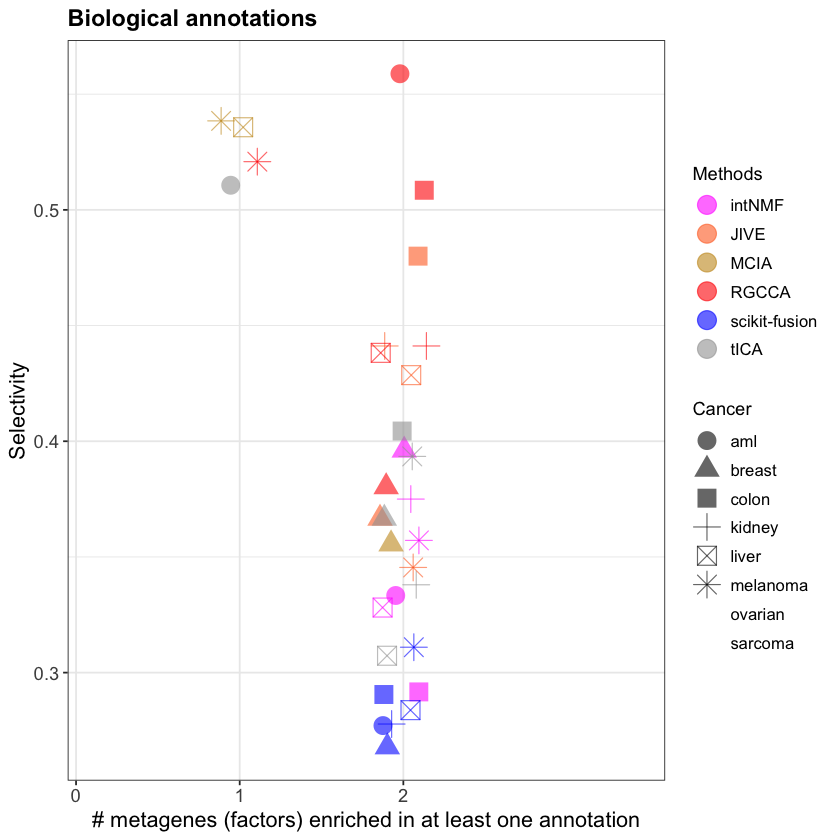

In [39]:
#tiff("BioEnr_go_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
min_nonZero = min(biological_analysis[, "nonZeroFacs"]) 
max_nonZero = max(biological_analysis[, "nonZeroFacs"]) 
g <- ggplot(biological_analysis, 
            aes(x=nonZeroFacs,y=selectivity)) + 
    geom_point(aes(colour = methods, shape = cancer), size=5, alpha=.6, position=position_jitter(h=0, w=0.15))+ 
    theme_bw()  + 
    scale_color_manual(values=c('#FF00FF', '#FF6E28', '#C8961E', '#FF0000', '#0000FF', '#A0A0A0', '#48D1CC', '#00FF00')) +
    ylim(floor(min((biological_analysis[,"selectivity"]*10)-.4)) / 10,
         ceiling(max((biological_analysis[,"selectivity"]*10)+.2)) / 10) +
    labs(title="Biological annotations", 
         x="# metagenes (factors) enriched in at least one annotation") +
    theme(plot.title = element_text(size=14,face="bold"),
          axis.text = element_text(size=11),
          axis.title = element_text(size=13),
          legend.text=element_text(size=10)) +
    ylab("Selectivity") + 
    labs(colour = "Methods", shape = "Cancer") +
    guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3)) + 
    #scale_x_discrete() + scale_x_discrete(limits=min_nonZero:max_nonZero) + 
    scale_x_discrete(limits=min_nonZero:max_nonZero, labels = c(min_nonZero:max_nonZero));
g
#dev.off()

ggsave(paste0(results_folder, "biological_annotations.pdf"),dpi=300)
ggsave(paste0(results_folder, "biological_annotations.png"),dpi=300) 

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Saving 7 x 7 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Saving 7 x 7 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”


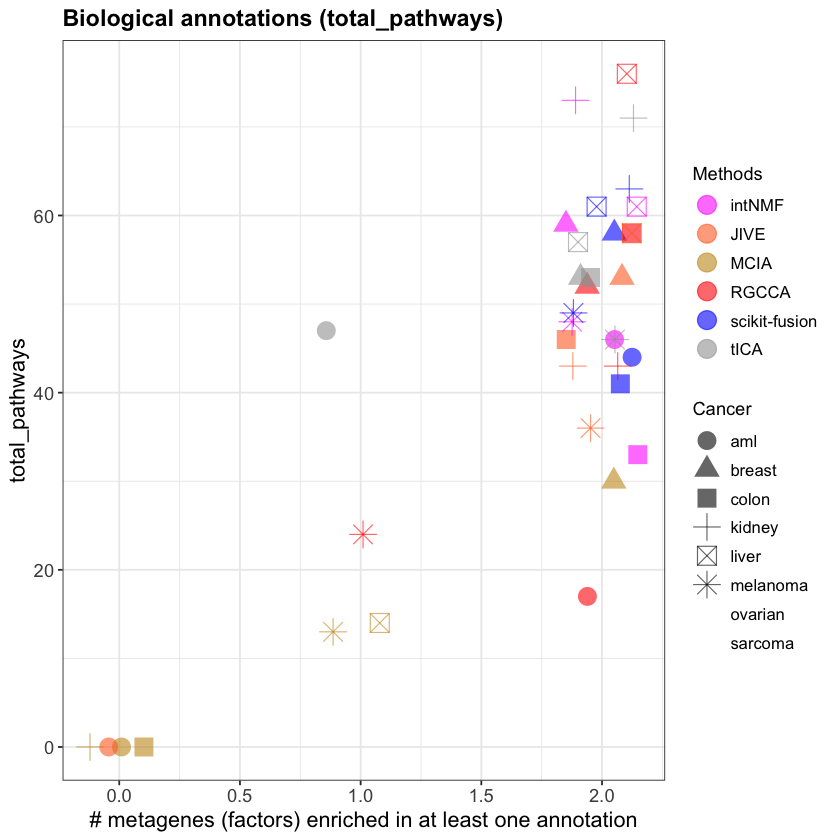

In [35]:
#tiff("BioEnr_go_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
min_nonZero = min(biological_analysis[, "total_pathways"]) 
max_nonZero = max(biological_analysis[, "total_pathways"]) 
g <- ggplot(biological_analysis, 
            aes(x=nonZeroFacs,y=total_pathways)) + 
    geom_point(aes(colour = methods, shape = cancer), size=5, alpha=.6, position=position_jitter(h=0, w=0.15))+ 
    theme_bw()  + 
    scale_color_manual(values=c('#FF00FF', '#FF6E28', '#C8961E', '#FF0000', '#0000FF', '#A0A0A0', '#48D1CC', '#00FF00')) +
    labs(title="Biological annotations (total_pathways)", 
         x="# metagenes (factors) enriched in at least one annotation") +
    theme(plot.title = element_text(size=14,face="bold"),
          axis.text = element_text(size=11),
          axis.title = element_text(size=13),
          legend.text=element_text(size=10)) +
    ylab("total_pathways") + 
    labs(colour = "Methods", shape = "Cancer") +
    guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3))
    #scale_x_discrete() + scale_x_discrete(limits=min_nonZero:max_nonZero) + 
    #scale_x_discrete(limits=min_nonZero:max_nonZero, labels = c(min_nonZero:max_nonZero));
g
#dev.off()

ggsave(paste0(results_folder, "biological_annotations_total_pathways.pdf"),dpi=300)
ggsave(paste0(results_folder, "biological_annotations_total_pathways.png"),dpi=300) 

## Plots of the obtained results with respect to clinical annotations
Plots are then created accordingly to Figure 4 and Supp Figure 2 of the paper.

In [36]:
library(ggplot2)

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Saving 7 x 7 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Saving 7 x 7 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”


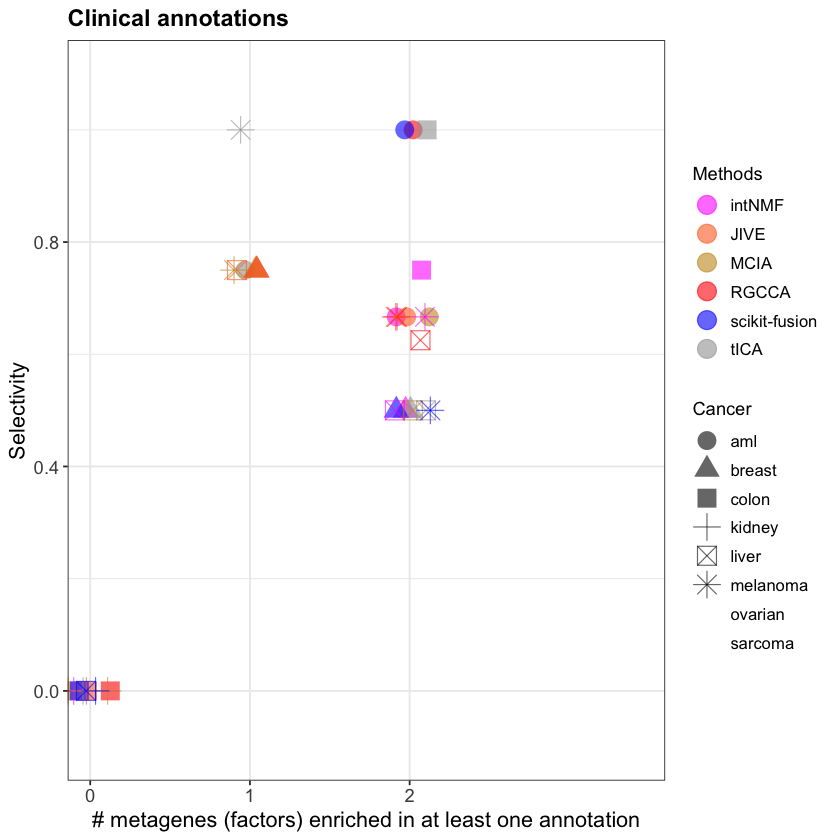

In [38]:
#tiff("BioEnr_go_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
min_nonZero = min(clinical_analysis[, "nonZeroFacs"]) 
max_nonZero = max(clinical_analysis[, "nonZeroFacs"]) 
g <- ggplot(clinical_analysis, 
            aes(x=nonZeroFacs, y=selectivity)) + 
    geom_point(aes(colour = methods, shape = cancer), size=5, alpha=.6, position=position_jitter(h=0, w=0.15))+ 
    theme_bw() + 
    scale_color_manual(values=c('#FF00FF', '#FF6E28', '#C8961E', '#FF0000', '#0000FF', '#A0A0A0', '#48D1CC', '#00FF00')) +
    ylim(floor(min((clinical_analysis[,"selectivity"]*10)-.4)) / 10,
         ceiling(max((clinical_analysis[,"selectivity"]*10)+.2)) / 10) +
    labs(title="Clinical annotations", 
         x="# metagenes (factors) enriched in at least one annotation") +
    theme(plot.title = element_text(size=14,face="bold"),
          axis.text = element_text(size=11),
          axis.title = element_text(size=13),
          legend.text=element_text(size=10)) +
    ylab("Selectivity") + 
    labs(colour = "Methods",shape="Cancer") +
    guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3)) + 
    #scale_x_discrete() + scale_x_discrete(limits=min_nonZero:max_nonZero) + 
    scale_x_discrete(limits=min_nonZero:max_nonZero, labels = c(min_nonZero:max_nonZero));
g
#dev.off()

ggsave(paste0(results_folder, "clinical_annotations.pdf"),dpi=300)
ggsave(paste0(results_folder, "clinical_annotations.png"),dpi=300) 